<a href="https://colab.research.google.com/github/Subhajit-Paul/ocelot23/blob/Ahan/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00


In [2]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import cv2
image=cv2.imread('/content/drive/MyDrive/ocelot2023_v0.1.2/images/train/tissue/080.jpg')






In [5]:
import numpy as np

def crop_img(img, size, stride):
    # This function crops an image using the sliding window technique. Size is the patch size of the sliding window and stride is the stride of the sliding window patches.
    cropped_img = []
    size_x = img.shape[1]
    size_y = img.shape[0]
    x = np.arange(0, size_x, stride)
    y = np.arange(0, size_y, stride)
    x = [i for i in x if i+size <= size_x]
    y = [i for i in y if i+size <= size_y]
    x.append(size_x - size)
    y.append(size_y - size)
    x = np.unique(x)
    y = np.unique(y)
    for i in x:
        for j in y:
            cropped_img.append(img[j:j+size, i:i+size])
    return cropped_img


In [6]:
patches = crop_img(image, size=256, stride=128)


In [7]:
# this function creates the segmentation model by adding a dropout layer before the output softmax layer.
# different backbones can be used. num_classes is the number of classes to segment. One can change the input patch size as well.
# model_dp is the segmentation model to train. preprocess_input is the preprocessing input for the input patches to the model. In case of InceptionV3 this function
# rescales the input patches from [0,256] to [-1,1].

import tensorflow
import segmentation_models as sm
sm.set_framework('tf.keras')


BACKBONE = 'inceptionv3'
activation='softmax'
encoder_freeze = False
num_classes = 3


preprocess_input = sm.get_preprocessing(BACKBONE)
def model(dropout_value):
    preprocess_input = sm.get_preprocessing(BACKBONE)
    model = sm.Unet(BACKBONE,
                    input_shape = (256,256,3),
                    encoder_weights='imagenet',
                    classes=num_classes,
                    activation=activation,
                    encoder_freeze = encoder_freeze)
    model.summary()
    model_input = model.input
    model_output = model.get_layer('final_conv').output
    model_output = tensorflow.keras.layers.Dropout(dropout_value)(model_output)
    output = tensorflow.keras.layers.Activation(activation, name=activation)(model_output)
    model_dp = tensorflow.keras.models.Model(model_input, output)
    return model_dp, preprocess_input

In [8]:
dropout_value = 0.4  # Example dropout value
model_dp, preprocess_input = model(dropout_value)

model_dp.load_weights('/content/drive/MyDrive/inceptionv3_TUMORRRRR_CHANNEL_all_02.hdf5')




87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [9]:
preprocessed_images = []
for patches in patches:
    preprocessed_image = preprocess_input(patches)
    preprocessed_image = preprocessed_image[np.newaxis, ...]  # Add an extra dimension
    preprocessed_images.append(preprocessed_image)

preprocessed_images = np.concatenate(preprocessed_images, axis=0)


In [10]:
preprocessed_images.shape

(49, 256, 256, 3)

In [11]:
predictions = model_dp.predict(preprocessed_images)


2/2 [==============================] - 33s 11s/step


In [67]:
predictions.shape

(49, 256, 256, 3)

In [12]:
pred_np=predictions


In [13]:
import numpy as np

# Assuming you have the image array with shape (16, 256, 256, 3) called "image"

# Calculate argmax across the channels
argmax_image = np.argmax(pred_np, axis=-1)

# Print the shape of the merged image
print("Merged Image Shape:", argmax_image.shape)


Merged Image Shape: (49, 256, 256)


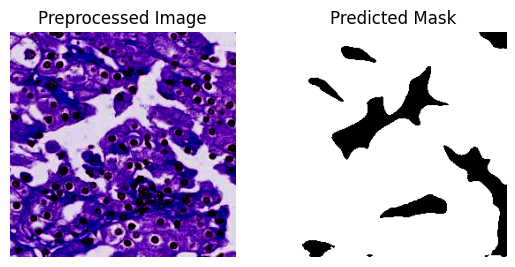

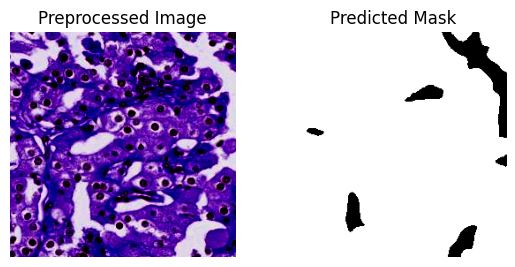

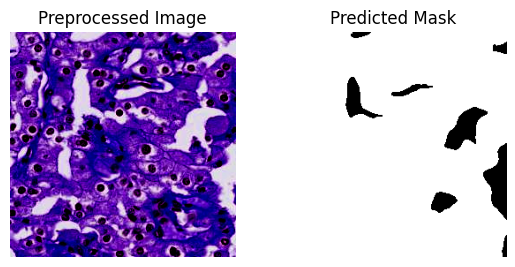

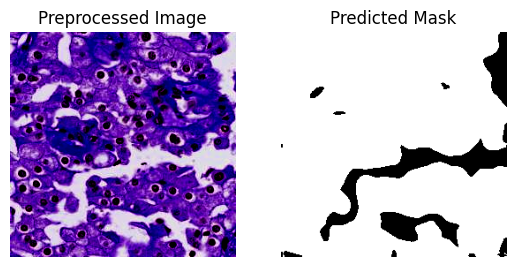

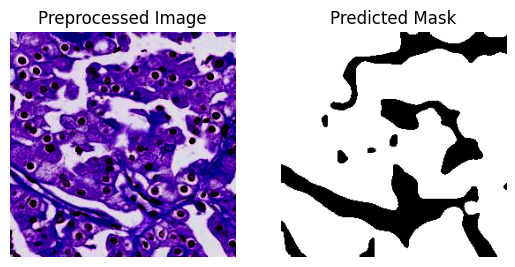

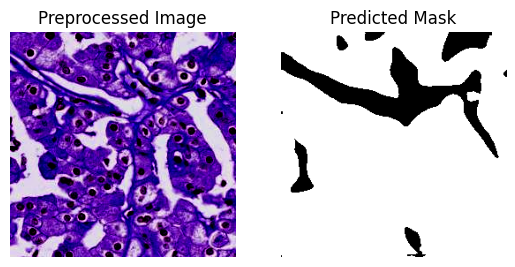

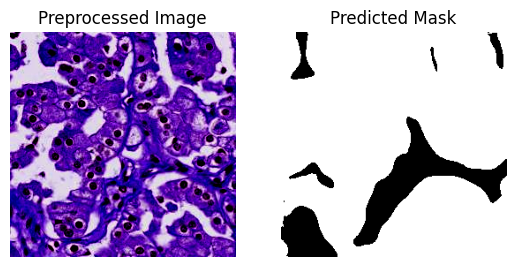

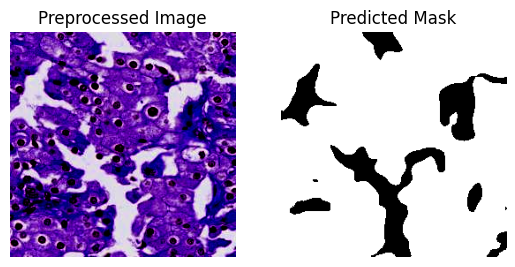

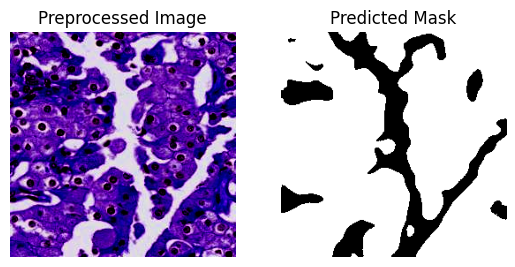

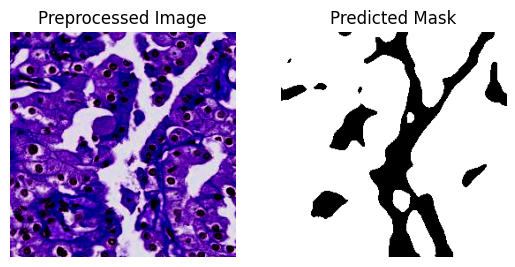

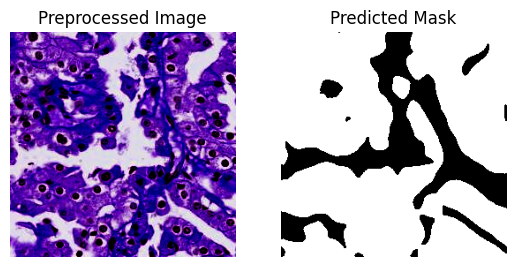

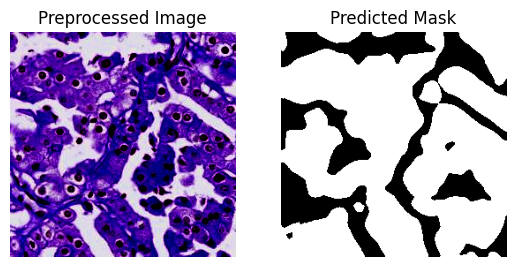

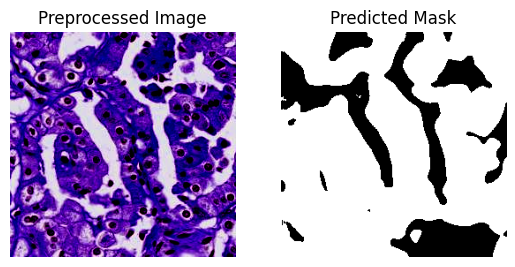

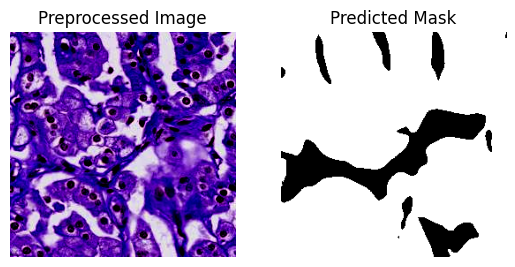

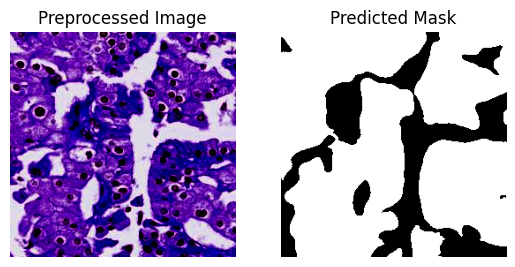

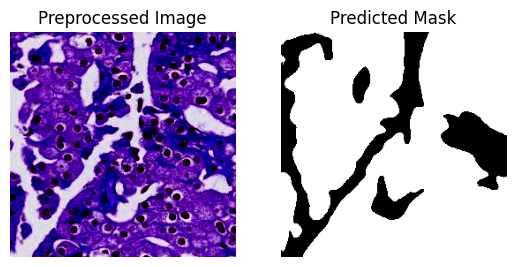

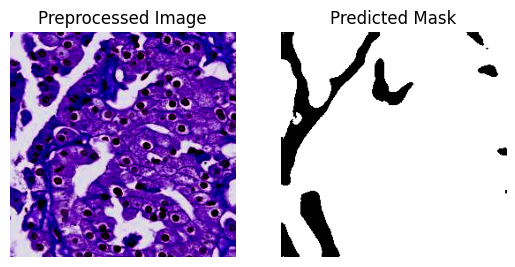

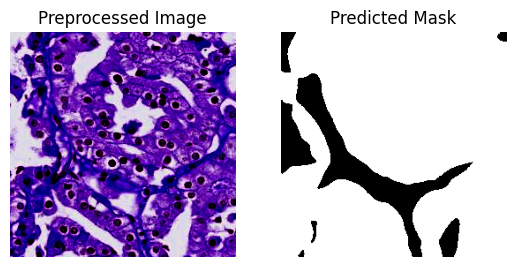

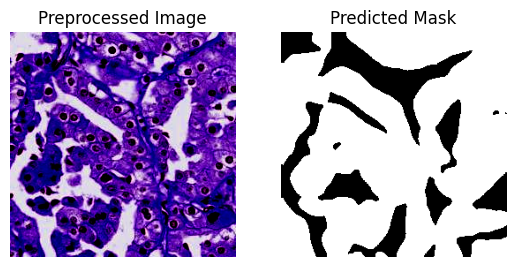

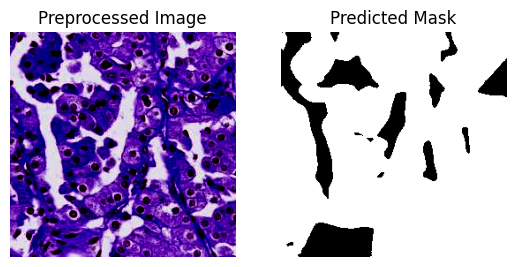

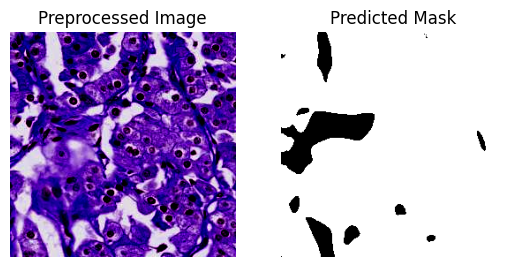

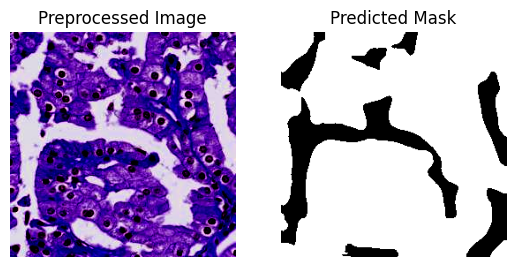

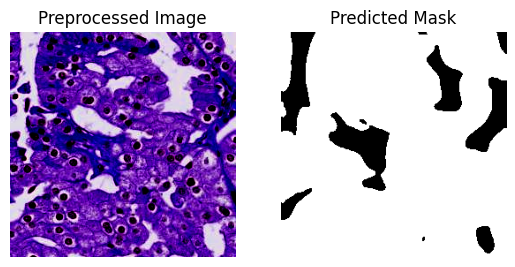

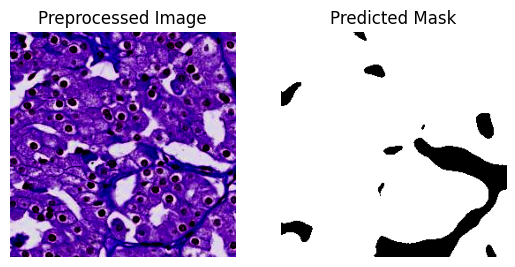

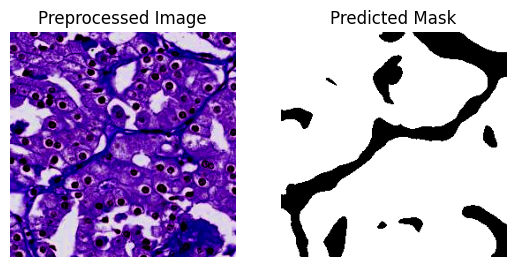

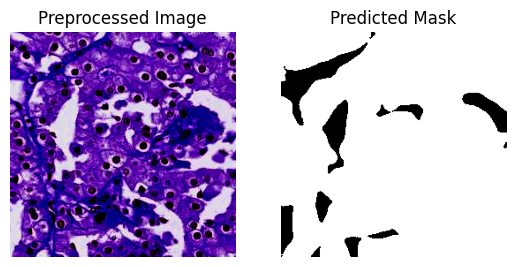

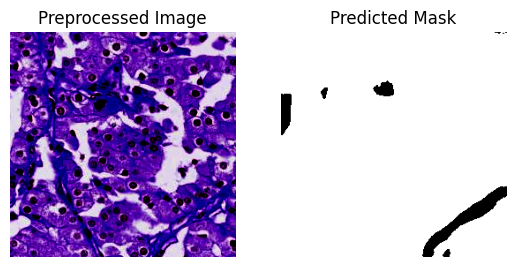

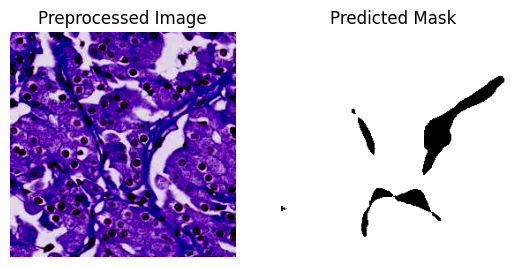

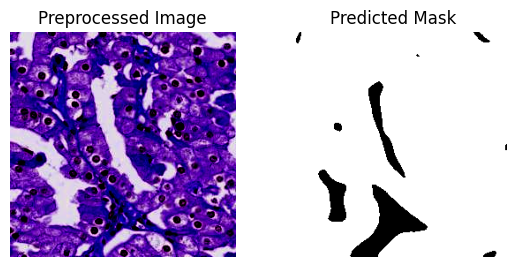

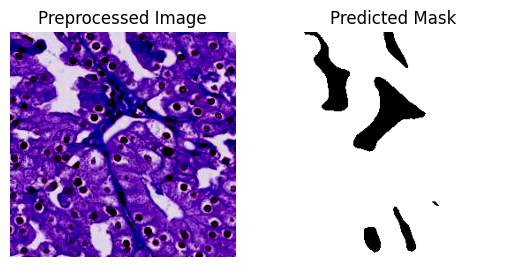

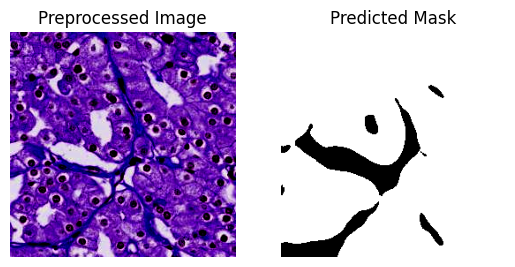

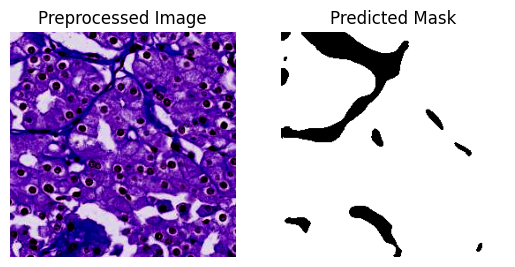

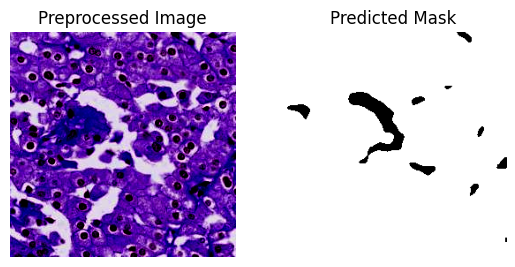

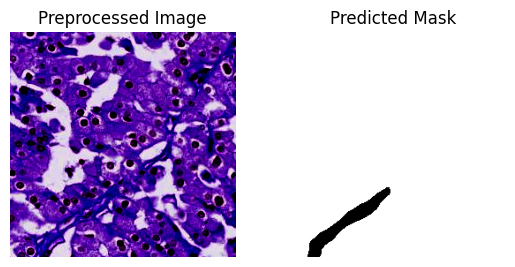

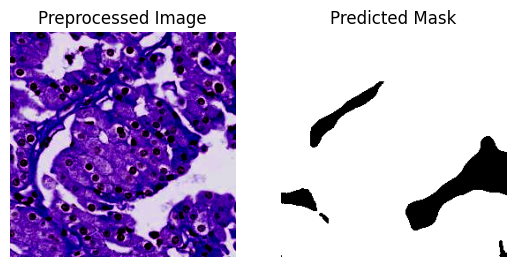

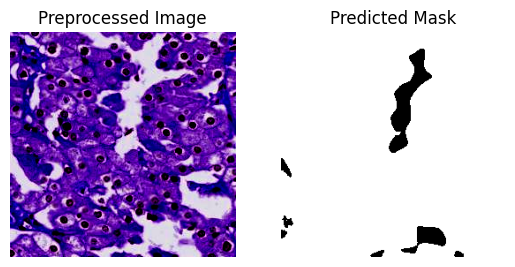

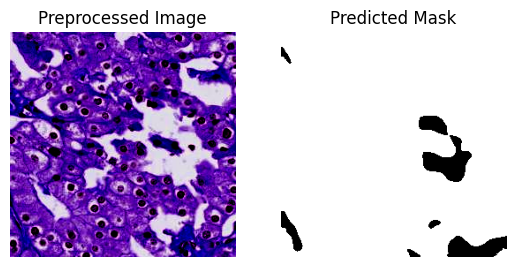

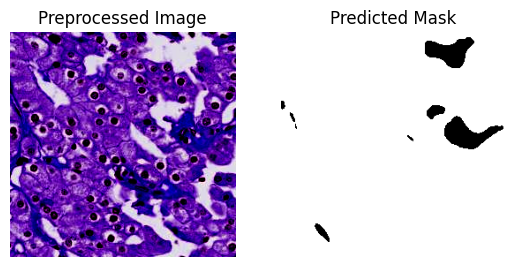

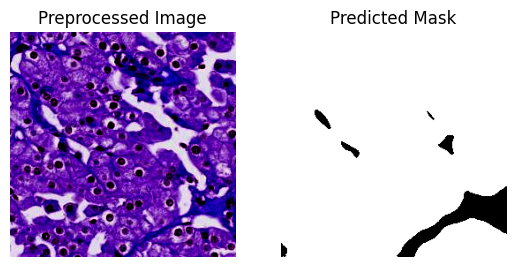

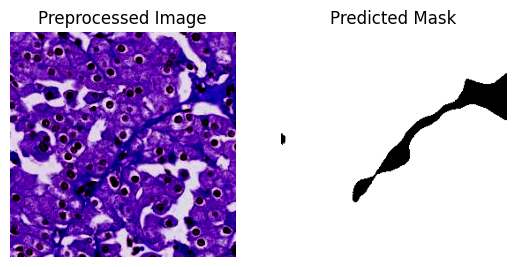

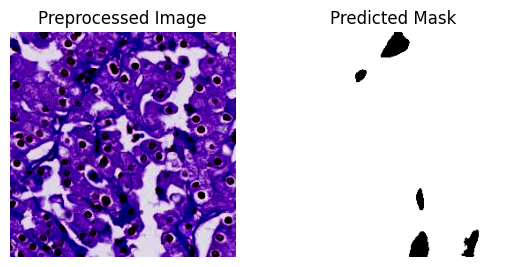

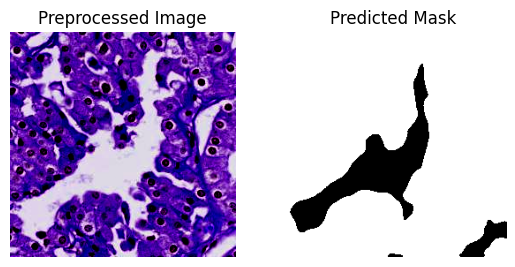

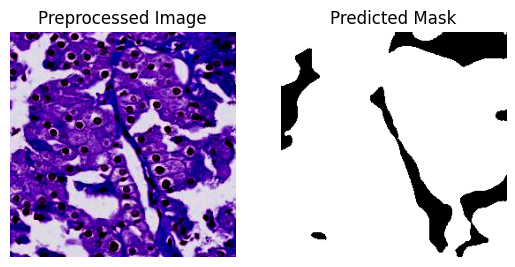

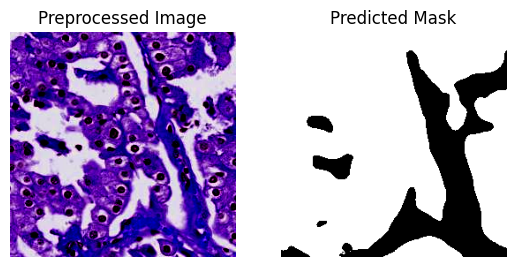

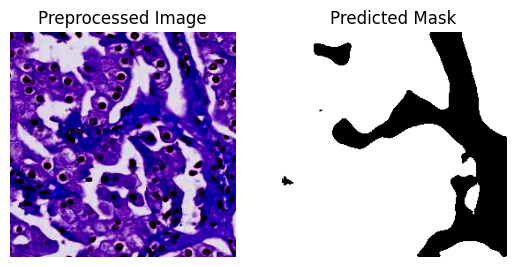

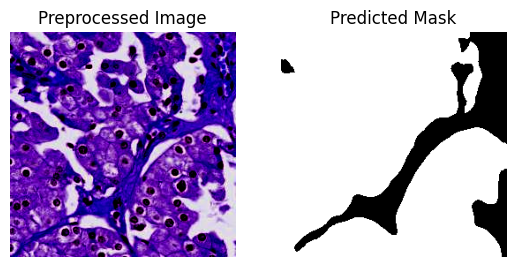

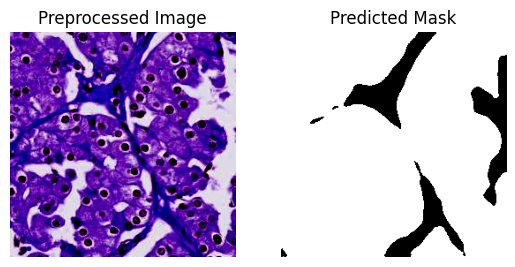

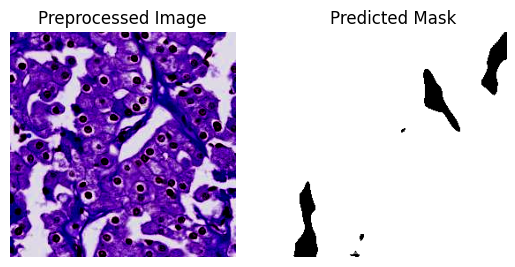

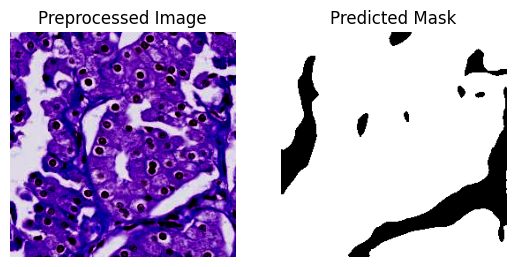

In [14]:
import matplotlib.pyplot as plt

# Assuming you have the preprocessed images stored in the variable 'preprocessed_images'
# Assuming you have the predictions stored in the variable 'predictions'

# Iterate over each prediction
for i in range(len(preprocessed_images)):
    # Get the preprocessed image and its corresponding prediction
    preprocessed_image = preprocessed_images[i]
    prediction = argmax_image[i]

    # Convert prediction to single-channel grayscale mask
    #grayscale_mask = np.sum(prediction, axis=-1)

    # Plot the preprocessed image
    plt.subplot(1, 2, 1)
    plt.imshow(preprocessed_image)
    plt.axis('off')
    plt.title('Preprocessed Image')

    # Plot the grayscale mask
    plt.subplot(1, 2, 2)
    plt.imshow(argmax_image[i][:,:,None], cmap='gray')
    plt.axis('off')
    plt.title('Predicted Mask')

    # Show the plot for each prediction
    plt.show()


Converting to original image

In [43]:
import numpy as np

def merge_patches(cropped_img, original_size, stride):
    # This function merges the cropped image patches back into a single image.
    size = cropped_img[0].shape[0]  # Size of each patch
    rows = (original_size[0] - size) // stride + 1  # Number of rows in the merged image
    cols = (original_size[1] - size) // stride + 1  # Number of columns in the merged image
    merged_img = np.zeros((original_size[0], original_size[1]))

    index = 0
    for i in range(rows):
        for j in range(cols):
            merged_img[i * stride : i * stride + size, j * stride : j * stride + size] = cropped_img[index]
            index += 1

    return merged_img


In [45]:
original_size = (1024, 1024)
patch_size = 256
stride = 128


# Merge the cropped patches back into a single image
reconstructed_image = merge_patches(argmax_image, original_size, stride)


In [52]:
reconstructed_image.shape

(1024, 1024)

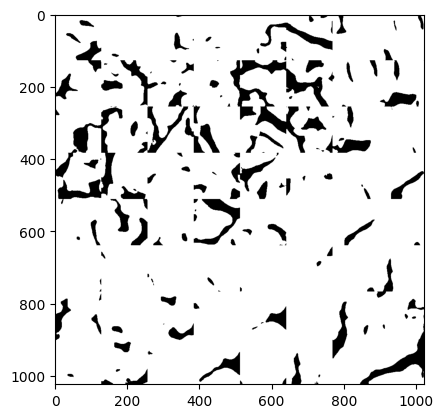

In [51]:
from google.colab.patches import cv2_imshow
plt.imshow(reconstructed_image[:,:,None], cmap='gray')

Inference Part (Testing)

In [74]:
def extract_predictions(patch):
    predicted_cells = []

    # Find connected components in the segmentation mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(patch, connectivity=8)

    # Iterate over the connected components and add them as predicted cells
    for label, stat, centroid in zip(range(1, num_labels), stats[1:], centroids[1:]):
        x = int(centroid[0])  # X-coordinate of the centroid
        y = int(centroid[1])  # Y-coordinate of the centroid
        cls = label  # Class label
        score = patch[int(centroid[1]), int(centroid[0])]  # Score from the patch
        predicted_cells.append((x, y, cls, score))

    return predicted_cells


In [75]:
def infer1(model, preprocess_input, cell_patches):
    # Initialize the list to store predicted cells
    predicted_cells = []

    # Iterate over the cell patches
    for patch in cell_patches:
        # Preprocess the input cell patch
        preprocessed_patch = preprocess_input(patch)

        # Reshape the input cell patch to match the model's input shape
        preprocessed_patch = tf.expand_dims(preprocessed_patch, axis=0)

        # Perform inference
        logits = model.predict(preprocessed_patch)

        # Post-process the logits to get the predicted cells
        segmentation_mask = np.argmax(logits, axis=-1)

        # Extract predictions from the patch
        patch_predictions = extract_predictions(segmentation_mask)

        # Update the predicted cells list
        predicted_cells.extend(patch_predictions)

    return predicted_cells


In [80]:
import numpy as np
from typing import List, Tuple

def get_predicted_cells(predictions: np.ndarray) -> List[Tuple[int, int, int, float]]:
    """
    Retrieves the predicted cells from the given predictions.

    Parameters
    ----------
    predictions : numpy.ndarray
        The predicted mask patches with shape (49, 256, 256).

    Returns
    -------
    List[Tuple[int, int, int, float]]:
        For each predicted cell, a tuple (x, y, cls, score) is provided.
    """

    # Reshape the patches to (49, 256*256)
    reshaped_patches = predictions.reshape(49, -1)

    predicted_cells = []

    # Iterate over the patches
    for i, patch in enumerate(reshaped_patches):
        # Find the index of the maximum probability in the patch
        max_prob_index = np.argmax(patch)

        # Calculate the x and y coordinates of the maximum probability
        x = max_prob_index % 256
        y = max_prob_index // 256

        # Calculate the class label and probability
        class_label = max_prob_index // (256 * 256)
        probability = patch[max_prob_index]

        # Change class 1 to 2
        if class_label == 1:
            class_label = 2

        # Change class 0 to 1
        if class_label == 0:
            class_label = 1

        predicted_cells.append((x, y, class_label, probability))

    return predicted_cells

# Example usage
predicted_mask_patches = predictions  # Replace with actual predicted mask patches
predicted_cells = get_predicted_cells(predicted_mask_patches)

for i, cell in enumerate(predicted_cells):
    x, y, class_label, probability = cell
    print(f"Cell {i+1}:")
    print(f"X: {x}, Y: {y}")
    print(f"Class Label: {class_label}, Probability: {probability}")
    print()


Cell 1:
X: 123, Y: 397
Class Label: 2, Probability: 0.9999964833259583

Cell 2:
X: 222, Y: 337
Class Label: 2, Probability: 0.9999982714653015

Cell 3:
X: 124, Y: 453
Class Label: 2, Probability: 0.9999949336051941

Cell 4:
X: 47, Y: 569
Class Label: 2, Probability: 0.9999985098838806

Cell 5:
X: 8, Y: 152
Class Label: 1, Probability: 0.9999991059303284

Cell 6:
X: 97, Y: 51
Class Label: 1, Probability: 0.999999463558197

Cell 7:
X: 68, Y: 368
Class Label: 2, Probability: 0.9999997019767761

Cell 8:
X: 222, Y: 283
Class Label: 2, Probability: 0.9999992251396179

Cell 9:
X: 2, Y: 314
Class Label: 2, Probability: 0.9999987483024597

Cell 10:
X: 90, Y: 235
Class Label: 1, Probability: 0.9999943375587463

Cell 11:
X: 223, Y: 537
Class Label: 2, Probability: 0.9999980330467224

Cell 12:
X: 223, Y: 153
Class Label: 1, Probability: 0.9999980330467224

Cell 13:
X: 187, Y: 444
Class Label: 2, Probability: 0.9999920725822449

Cell 14:
X: 193, Y: 342
Class Label: 2, Probability: 0.999999582767486